# Project Overview

This data set is created only for the learning purpose of the customer segmentation concepts, also known as market basket analysis. You are owing a supermarket mall and through membership cards, you have some basic data about your customers and want to understand the customers like who can be easily converge **Target Customer** so that the sense can be given to marketing team and plan the strategy accordingly. You can access the data [here](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

## Data Sets

The data is contained in one file:

* Mall_Costumers.csv - demographic data for each costumer and score

Here is the schema and explanation of each variable in the file:
* CostumerID - costumer id
* Gender - costumer gender
* Age - age of the costumer
* Annual Income (k$) - costumer's annual income
* Spending Score (1-100) - costumer's score based on behavior and purchansing data (higher the score, higher will be the customer expense)

# Libraries

In [367]:
# import libraries
import math

#Machine Learning
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Reading

In [368]:
# read in the json files
df = pd.read_csv('data/Mall_Customers.csv')

In [369]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 1. Data processing

- Renaming some columns names for better management
- Create a new "AGE_GROUP" column for better segmentation

In [370]:
# changing column names
df = df.rename(columns=
               {'CustomerID': 'USER_ID',
                'Gender': 'GENDER',
                'Age': 'AGE', 
                'Annual Income (k$)': 'ANNUAL_INCOME', 
                'Spending Score (1-100)': 'SPENDING_SCORE'})

#create age group column
df['AGE_GROUP'] = pd.cut(df['AGE'], 
                         bins=[17, 30, 40, 50, 60, 70],
                         labels=['18-30', '31-40', '41-50', '51-60', '61+'])

In [371]:
df.head()

,USER_ID,GENDER,AGE,ANNUAL_INCOME,SPENDING_SCORE,AGE_GROUP
0,1,Male,19,15,39,18-30
1,2,Male,21,15,81,18-30
2,3,Female,20,16,6,18-30
3,4,Female,23,16,77,18-30
4,5,Female,31,17,40,31-40


In [372]:
df.isnull().sum()

USER_ID           0
GENDER            0
AGE               0
ANNUAL_INCOME     0
SPENDING_SCORE    0
AGE_GROUP         0
dtype: int64

# CLUSTERING

### K-Means: Inertia

Inertia measures how well a dataset was clustered by K-Means. It is calculated by **measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster**.

A good model is one with **low inertia AND a low number of clusters (K)**. However, this is a tradeoff because as K increases, inertia decreases.

In [373]:
def calculate_inertias(data, k):
    '''
    Calculate the inertias 
    
    INPUT:
    data - Two-Dimensional Array with data to be analysed
    k - max number of clusters to be analysed
    
    OUTPUT:
    inertias - array with the inertias
    K - Range with the max number of clusters
    '''
    
    inertias = []
    K = range(1, k)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(data)

        inertias.append(kmeanModel.inertia_)
        
    return inertias, k, K

### Number of Clusters

To find the optimal K for a dataset, I am using the Elbow method. Basically, it's necessary to identift the point that indicates the balance between greater homogeneity and the greatest difference between clusters, this will be the point on the curve farthest from a straight line drawn between points P<sub>0</sub> and P<sub>1</sub>. Following the equation below:

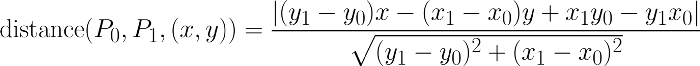

In [374]:
def optimal_number_of_clusters(inertias, k):
    '''
    Find the best number of clusters for a k points 
    
    INPUT: 
    inertias - inertias array (calculate by the calculate_inertias formula)
    k - max number of clusters to be analysed
    
    OUTPUT:
    n - optimal number of clusters
    x1, y1, x2, y2 - position of the first and last inertias points
    '''
    
    x1, y1 = 1, inertias[0]
    x2, y2 = k, inertias[len(inertias)-1]

    distances = []
    for i in range(len(inertias)):
        x0 = i+2
        y0 = inertias[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    n = distances.index(max(distances)) + 2
        
    return n, x1, y1, x2, y2

### K-Means Clustering

The [k-means clustering method](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet#:~:text=K%2DMeans%3A%20Inertia,number%20of%20clusters%20(%20K%20).) is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. There are many different types of clustering methods, but k-means is one of the oldest and most approachable.

### What Is Clustering?
Clustering is a set of techniques used to partition data into groups, or clusters. Clusters are loosely defined as groups of data objects that are more similar to other objects in their cluster than they are to data objects in other clusters. In practice, clustering helps identify two qualities of data:

- Meaningfulness
- Usefulness

**Meaningful clusters** expand domain knowledge. For example, in the medical field, researchers applied clustering to gene expression experiments. The clustering results identified groups of patients who respond differently to medical treatments.

**Useful clusters**, on the other hand, serve as an intermediate step in a data pipeline. For example, businesses use clustering for customer segmentation. The clustering results segment customers into groups with similar purchase histories, which businesses can then use to create targeted advertising campaigns.

In [375]:
def two_dimensional_clustering(data, k, x, y):
    '''
    Its a two dimensional clustering
    
    INPUT:
    data - Two-Dimensional Array with data to be analysed
    k - max number of clusters to be analysed
    x - The first column of the informed array 
    y - The second column of the informed array
    
    OUTPUT:
    clustering_df - dataframe with the clustered data
    centroids - array with the centroids of each cluster
    Elbow Chart - The elbow chart to visualize the best number of clusters
    Before Chart - Costumer segmentation by gender before the clustering
    After Chart - Costumer segmentation chart after the cluster with centroids
    '''
    
    #run the suport functions
    inertias, k1, K = calculate_inertias(data, k)
    n, x1, y1, x2, y2 = optimal_number_of_clusters(inertias, k1)
    
    #create a df with just necessary columns
    clustering_df = df.copy()
    clustering_df = clustering_df[['AGE', 'ANNUAL_INCOME', 'SPENDING_SCORE', 'USER_ID']]
    
    #run the algorithm
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300, 
                            tol=0.0001, random_state=42, algorithm='elkan') )

    #fit the algorithm
    algorithm.fit(data)

    #create a new column and set the labels of each cluster
    clustering_df['CLUSTERS'] = algorithm.labels_

    #find the centroids
    centroids = algorithm.cluster_centers_
    
    #------------------------------
    #First Chart - The Elbow Method
    #------------------------------
    
    #first fig size
    plt.figure(figsize=(16, 8))
    
    #labels and title
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    
    #plot the Elbow Method chart
    plt.plot(K, inertias, 'c-o') #elbow
    plt.plot([x2, x1], [y2,y1], color='g') #green line
    
    #-------------------------------------------------------------------------------------------
    #Second Chart Group - Plot the comparison between BEFORE and AFTER Clustering (scatter plot)
    #-------------------------------------------------------------------------------------------

    #second fig size
    plt.figure(figsize=(16, 8))
    
    #left chart 'BEFORE'
    plt.subplot(1, 2, 1)
    plt.title('BEFORE', fontsize=12)
    sns.set_style("whitegrid") #set white background

    splot = sns.scatterplot(data=df, 
                            x=x, 
                            y=y, 
                            hue="GENDER")

    #right chart 'AFTER'
    plt.subplot(1, 2, 2)
    plt.title('AFTER')
    sns.set_style("whitegrid") #set white background

    #plot the clustering dots
    ax = sns.scatterplot(data=clustering_df, 
                         x=x, 
                         y=y, 
                         hue='CLUSTERS', 
                         alpha=0.7, 
                         palette='bright')

    #plot the centroids dots
    ax = sns.scatterplot(x=centroids[: , 0],
                         y=centroids[: , 1],
                         s=150, legend=False,
                         ax=ax)
    
    plt.show() #shor chart
    
    return clustering_df, centroids

In [376]:
def plots(data):
    '''
    Return chars to see the AVG cluster income and score
    
    INPUT:
    data - clustered dataframe returned by the two_dimensional_clustering function
    
    OUTPUT:
    AVG Cluster Income chart
    AVG Cluster Score chart
    
    '''

    #data
    df = data.groupby('CLUSTERS', as_index=False)['ANNUAL_INCOME', 'SPENDING_SCORE'].mean()

    #costumer count by age group
    plt.figure(figsize=(16, 8))

    #---------------
    #Left side chart
    #---------------
    
    #plot
    plt.subplot(1, 2, 1)
    splot = sns.barplot(data=df, x='CLUSTERS', y='ANNUAL_INCOME', palette='Blues_d', ci=False)
    splot.set(ylabel=None)  # remove the axis label
    splot.set(yticklabels=[])  # remove the tick labels

    #labels and title
    plt.xlabel('CLUSTERS', fontsize=12)
    plt.title('AVG SCORE BY CLUSTERS', fontsize=12)

    #add annotations on each bar
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    
    #---------------
    #Right side chart
    #---------------
    
    plt.subplot(1, 2, 2)
    splot = sns.barplot(data=df, x='CLUSTERS', y='SPENDING_SCORE', palette='Blues_d', ci=False)

    #labels and title
    plt.xlabel('CLUSTERS', fontsize=12)
    plt.title('AVG INCOME BY CLUSTERS', fontsize=12)

    #hide borders, background and labels
    splot.set(ylabel=None)  # remove the axis label
    splot.set(yticklabels=[])  # remove the tick labels

    #add annotations on each bar
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

    sns.despine(left = True) #hide borders
    sns.set_style("white") #set white background

    plt.show()

    return

In [377]:
score_age_data = df[['AGE', 'SPENDING_SCORE']].to_numpy()
income_age_data = df[['AGE', 'ANNUAL_INCOME']].to_numpy()
income_score_data = df[['SPENDING_SCORE', 'ANNUAL_INCOME']].to_numpy()

# 2. Data Anaylsis

In [378]:
df.describe()

,USER_ID,AGE,ANNUAL_INCOME,SPENDING_SCORE
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


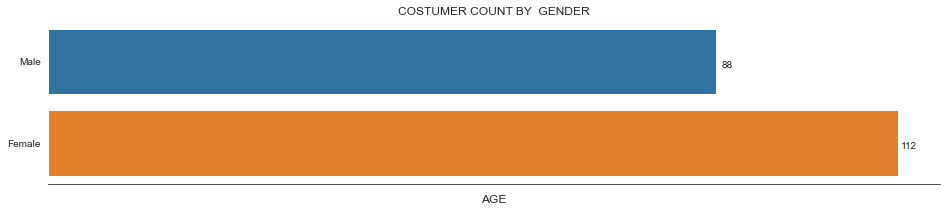

In [379]:
plt.figure(figsize=(16, 3))

#plot
splot = sns.countplot(data=df, y="GENDER")


#labels and title
plt.xlabel('AGE', fontsize=12)
plt.title('COSTUMER COUNT BY  GENDER', fontsize=12)

# Annotate every single Bar with its value, based on it's width           
for p in splot.patches:
    width = p.get_width()
    plt.text(1.5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:.0f}'.format(width),
             ha='center', va='center')

#hide borders, background
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(xticklabels=[])  # remove the tick labels

plt.show()

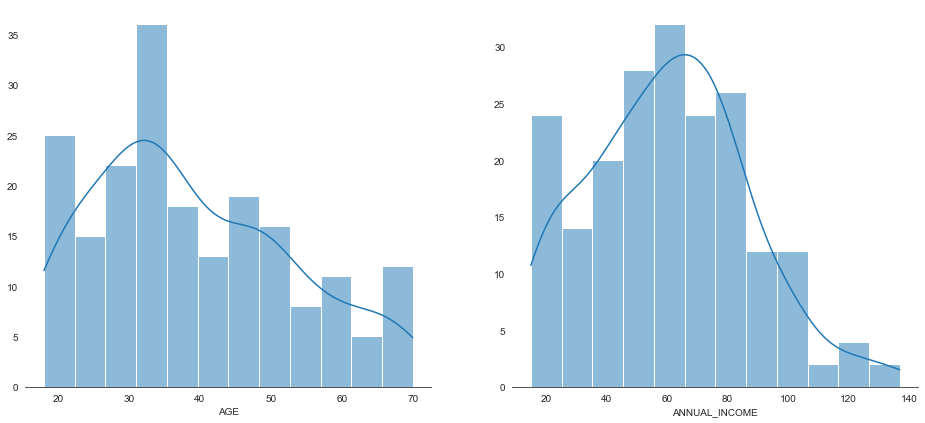

In [380]:
#users age and income
income_hist = df.groupby(['USER_ID'], as_index=False)['AGE', 'ANNUAL_INCOME'].mean()

#fig size
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 7)

#plot income histogram
plt.subplot(1, 2, 1)
splot = sns.histplot(data = income_hist, x='AGE', kde=True, bins=12);
splot.set(ylabel=None)  # remove the axis label

#plot income histogram
plt.subplot(1, 2, 2)
splot = sns.histplot(data = income_hist, x='ANNUAL_INCOME', kde=True, bins=12);
splot.set(ylabel=None)  # remove the axis label
#splot.set(yticklabels=[])  # remove the tick labels


#hide borders, background
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background

plt.show()

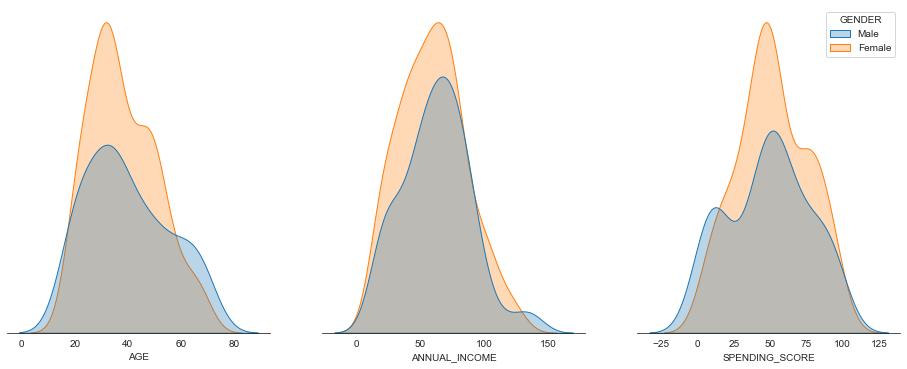

In [381]:
#age, income and score distribuction by gender
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16, 6)

#age distribution
plt.subplot(1, 3, 1)
splot = sns.kdeplot(data=df, x='AGE', hue='GENDER', fill=True, alpha=0.3, legend=False)
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#annual income distribution
plt.subplot(1, 3, 2)
splot = sns.kdeplot(data=df, x='ANNUAL_INCOME', hue='GENDER', fill=True, alpha=0.3, legend=False)
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#score distribution
plt.subplot(1, 3, 3)
splot = sns.kdeplot(data=df, x='SPENDING_SCORE', hue='GENDER', fill=True, alpha=0.3, legend=True)
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background

plt.show()

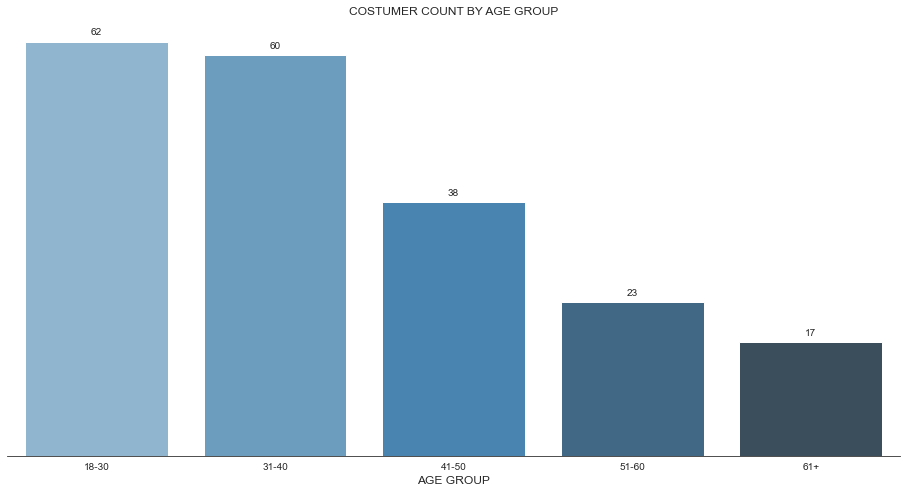

In [382]:
#costumer count by age group
plt.figure(figsize=(16, 8))

#plot
splot = sns.countplot(data=df, x='AGE_GROUP', palette='Blues_d')

#labels and title
plt.xlabel('AGE GROUP', fontsize=12)
plt.title('COSTUMER COUNT BY AGE GROUP', fontsize=12)

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

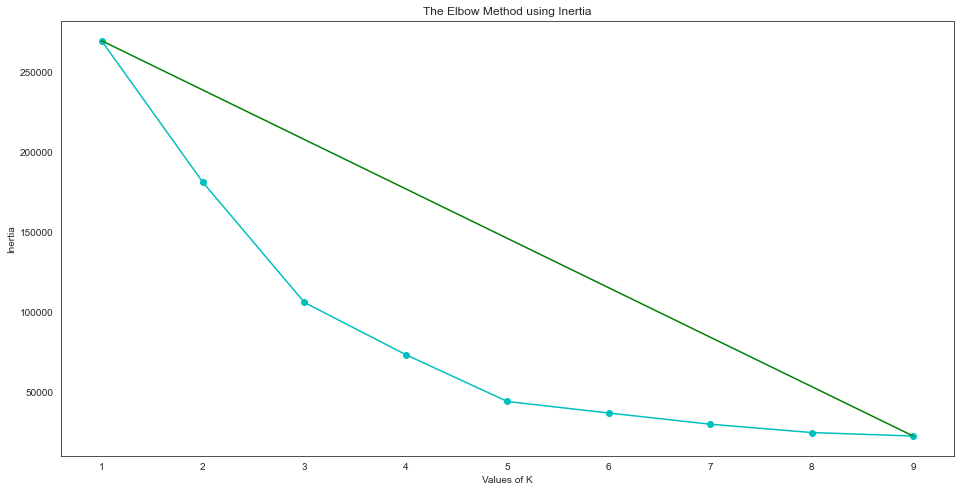

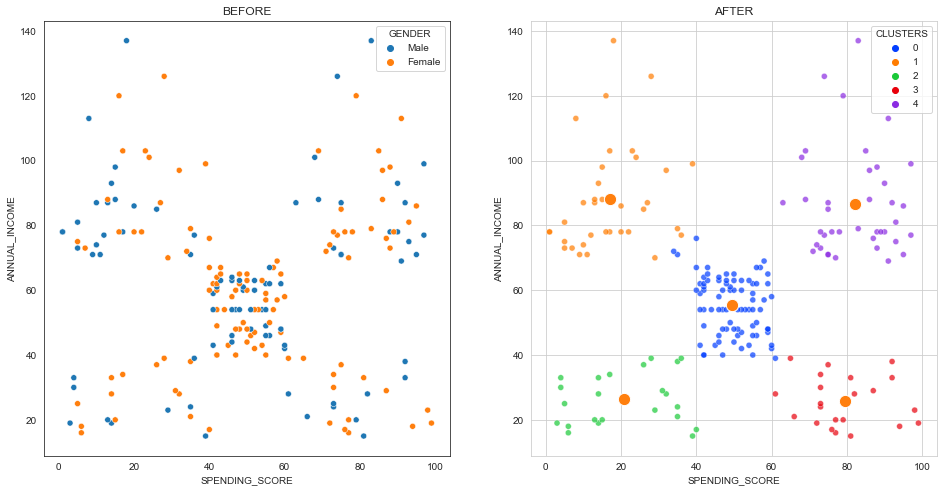

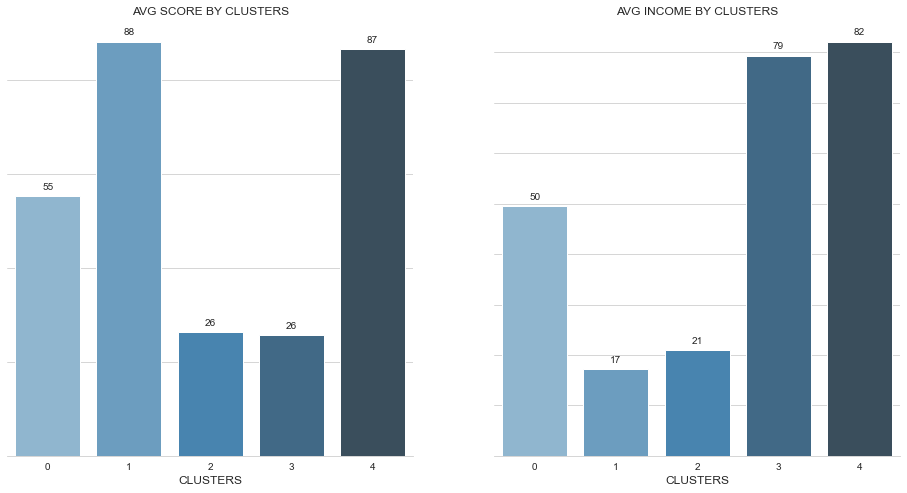

In [383]:
#numpy array
income_score_data = df[['SPENDING_SCORE', 'ANNUAL_INCOME']].to_numpy()

#call function
clustering_income_score, centroids = two_dimensional_clustering(income_score_data, 10, df['SPENDING_SCORE'], df['ANNUAL_INCOME'])
plots(clustering_income_score)

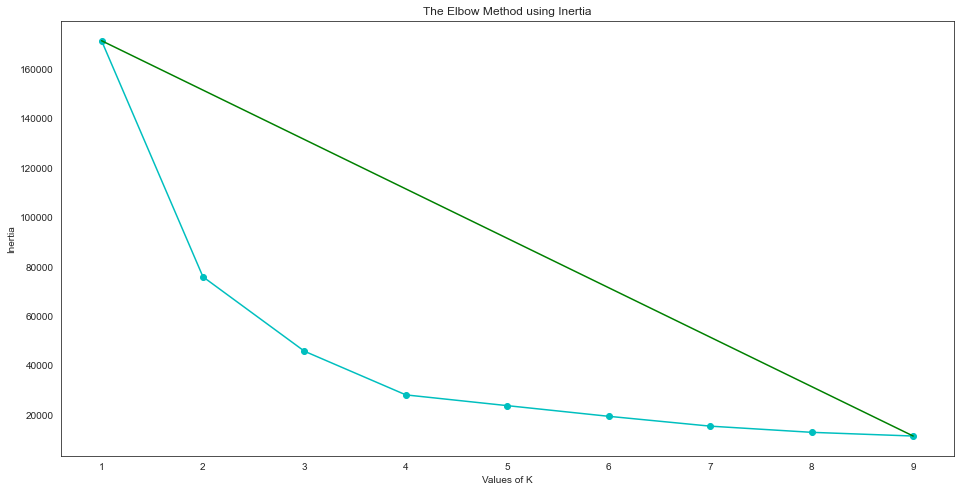

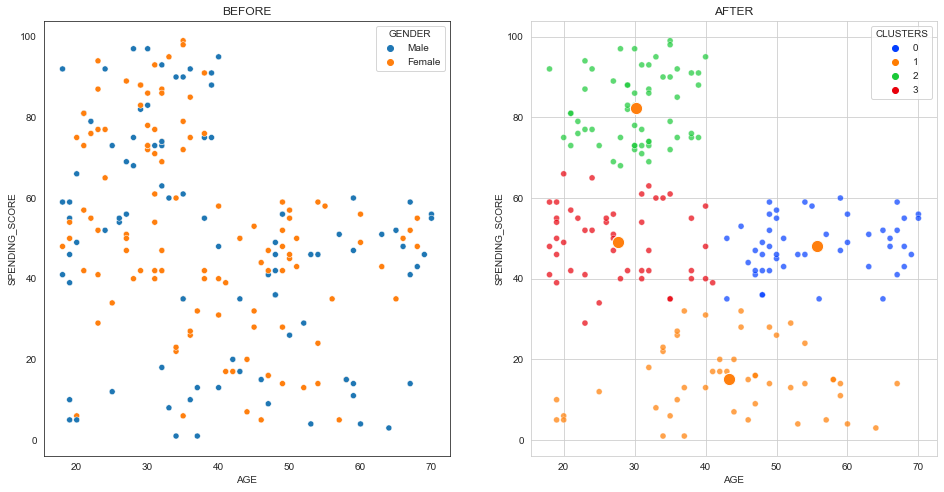

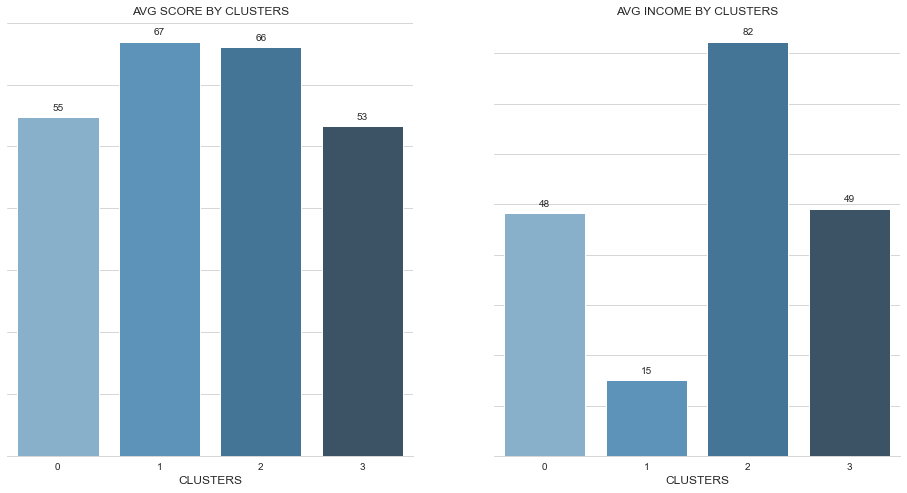

In [384]:
#numpy array
score_age_data = df[['AGE', 'SPENDING_SCORE']].to_numpy()

#call function
clustering_score_age, centroids = two_dimensional_clustering(score_age_data, 10, df['AGE'], df['SPENDING_SCORE'])
plots(clustering_score_age)

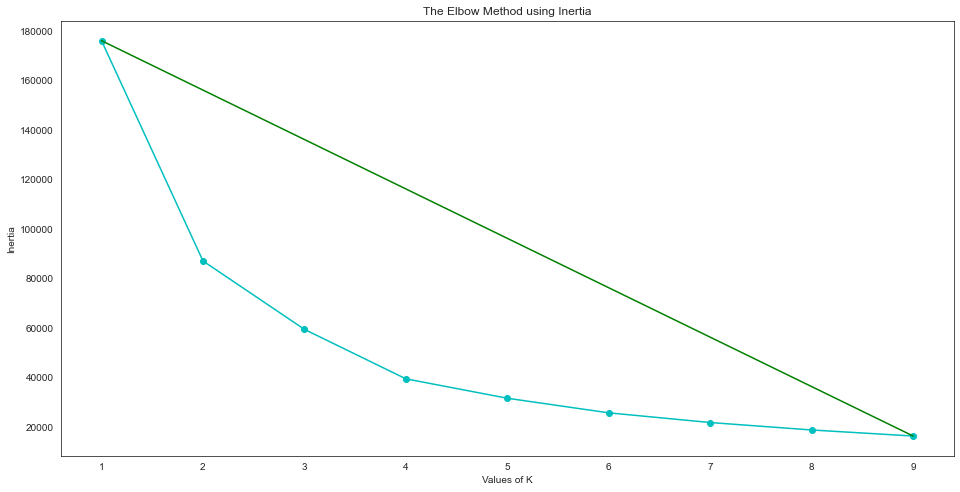

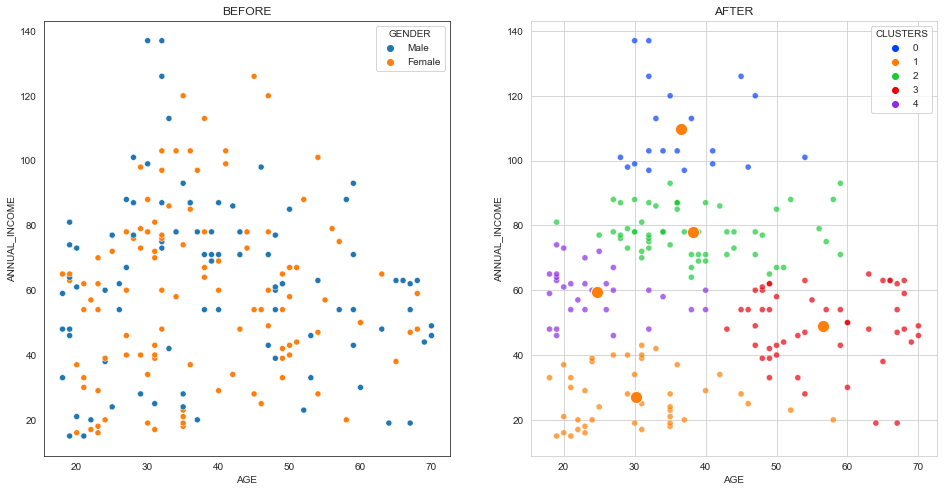

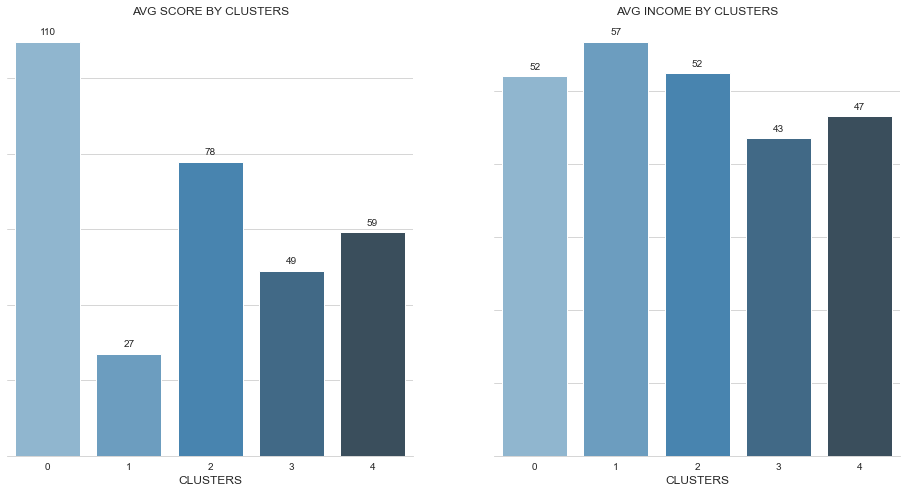

In [385]:
#numpy array
income_age_data = df[['AGE', 'ANNUAL_INCOME']].to_numpy()

#call function
clustering_income_age, centroids = two_dimensional_clustering(income_age_data, 10, df['AGE'], df['ANNUAL_INCOME'])
plots(clustering_income_age)